In [ ]:
# The standard Python science stack
from __future__ import annotations

import ensaio
import harmonica as hm
import numpy as np
import pandas as pd

# The Fatiando stack
import pooch

# Plotting maps using GMT
import pygmt

# For projections (wrapped for Proj)
import pyproj
import pyvista
import xarray as xr

In [7]:
# download gravity data
fname = ensaio.fetch_bushveld_gravity(version=1)
data = pd.read_csv(fname)
# Project to mercator
projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
data["easting"], data["northing"] = projection(data.longitude, data.latitude)
data

,longitude,latitude,height_sea_level_m,height_geometric_m,gravity_mgal,gravity_disturbance_mgal,gravity_bouguer_mgal,easting,northing
0,25.01500,-26.26334,1230.2,1257.474535,978681.38,25.081592,-113.259165,2.526066e+06,-2.733052e+06
1,25.01932,-26.38713,1297.0,1324.574150,978669.02,24.538158,-122.662101,2.526503e+06,-2.746924e+06
2,25.02499,-26.39667,1304.8,1332.401322,978669.28,26.526960,-121.339321,2.527075e+06,-2.747994e+06
3,25.04500,-26.07668,1165.2,1192.107148,978681.08,17.954814,-113.817543,2.529096e+06,-2.712163e+06
4,25.07668,-26.35001,1262.5,1289.971792,978665.19,12.700307,-130.460126,2.532295e+06,-2.742763e+06
...,...,...,...,...,...,...,...,...,...
3872,31.51500,-23.86333,300.5,312.710241,978776.85,-4.783965,-39.543608,3.182450e+06,-2.466945e+06
3873,31.52499,-23.30000,280.7,292.686630,978798.55,48.012766,16.602026,3.183459e+06,-2.405224e+06
3874,31.54832,-23.19333,245.7,257.592670,978803.55,49.161771,22.456674,3.185814e+06,-2.393567e+06
3875,31.57333,-23.84833,226.8,239.199065,978808.44,5.116904,-20.419870,3.188340e+06,-2.465298e+06


In [242]:
# download topo data
url_topo = (
    "https://github.com/fatiando/transform21/raw/main/data/bushveld_topography.nc"
)
md5_topo = "md5:62daf6a114dda89530e88942aa3b8c41"
path_topo = pooch.retrieve(url_topo, known_hash=md5_topo)
topography = xr.load_dataarray(path_topo)
topography

<xarray.DataArray 'bedrock' (latitude: 240, longitude: 419)>
array([[1257., 1260., 1266., ...,  195.,  201.,  425.],
       [1245., 1254., 1261., ...,  206.,  215.,  375.],
       [1256., 1258., 1268., ...,  200.,  232.,  300.],
       ...,
       [1029., 1031., 1033., ...,  248.,  242.,  238.],
       [1029., 1031., 1033., ...,  247.,  242.,  237.],
       [1028., 1030., 1032., ...,  247.,  241.,  238.]])
Coordinates:
  * longitude  (longitude) float64 25.02 25.03 25.05 25.07 ... 31.95 31.97 31.98
  * latitude   (latitude) float64 -27.0 -26.98 -26.97 ... -23.05 -23.03 -23.02
Attributes:
    long_name:       Bedrock relief
    actual_range:    [-10898.   8271.]
    units:           meters
    vertical_datum:  sea level
    datum:           WGS84

Calculate region boundaries and map projection in meters

In [9]:
# set figure height, width and map scale
fig_height = 180  # in mm

spacing = 10000

e, w = data.easting.min() // spacing * spacing, data.easting.max() // spacing * spacing
n, s = (
    data.northing.min() // spacing * spacing,
    data.northing.max() // spacing * spacing,
)
# e, w = data.easting.min(), data.easting.max()
# n, s = data.northing.min(), data.northing.max()
fig_width = fig_height * (w - e) / (s - n)
fig_ratio = (s - n) / (fig_height / 1000)
# Make a GMT region string and projection strings in both ESPG3031 and Lat/Lon
fig_reg = f"{e}/{w}/{n}/{s}"
fig_proj = f"x1:{fig_ratio}"
fig_proj_ll = f"s0/-90/-71/1:{fig_ratio}"
fig_reg

'2520000.0/3230000.0/-2820000.0/-2380000.0'

re-project topography grid into meters

In [112]:
# projection = pyproj.Proj(proj="merc", lat_ts=data.latitude.mean())
# da_topo = vd.project_grid(topography, projection=projection)

# Convert to pandas dataframe
df_topo = topography.to_dataframe().reset_index()
# Project to mercator
projection = pyproj.Proj(proj="merc", lat_ts=df_topo.latitude.mean())
df_topo["x"], df_topo["y"] = projection(df_topo.longitude, df_topo.latitude)

df_topo = pygmt.blockmedian(
    data=df_topo[["x", "y", "bedrock"]], region=fig_reg, spacing=spacing
)
da_topo = pygmt.surface(data=df_topo, region=fig_reg, spacing=spacing, registration="g")

pygmt.grdinfo(da_topo)

surface [WARNING]: Your grid dimensions are mutually prime.  Convergence is very unlikely.


': Title: \n: Command: \n: Remark: \n: Gridline node registration used [Cartesian grid]\n: Grid file format: nf = GMT netCDF format (32-bit float), CF-1.7\n: x_min: 2520000 x_max: 3230000 x_inc: 10000 name: x n_columns: 72\n: y_min: -2820000 y_max: -2380000 y_inc: 10000 name: y n_rows: 45\n: v_min: 90.652961731 v_max: 2126.38867188 name: z\n: scale_factor: 1 add_offset: 0\n: format: classic\n'

Use pygmt to plot the data.

psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


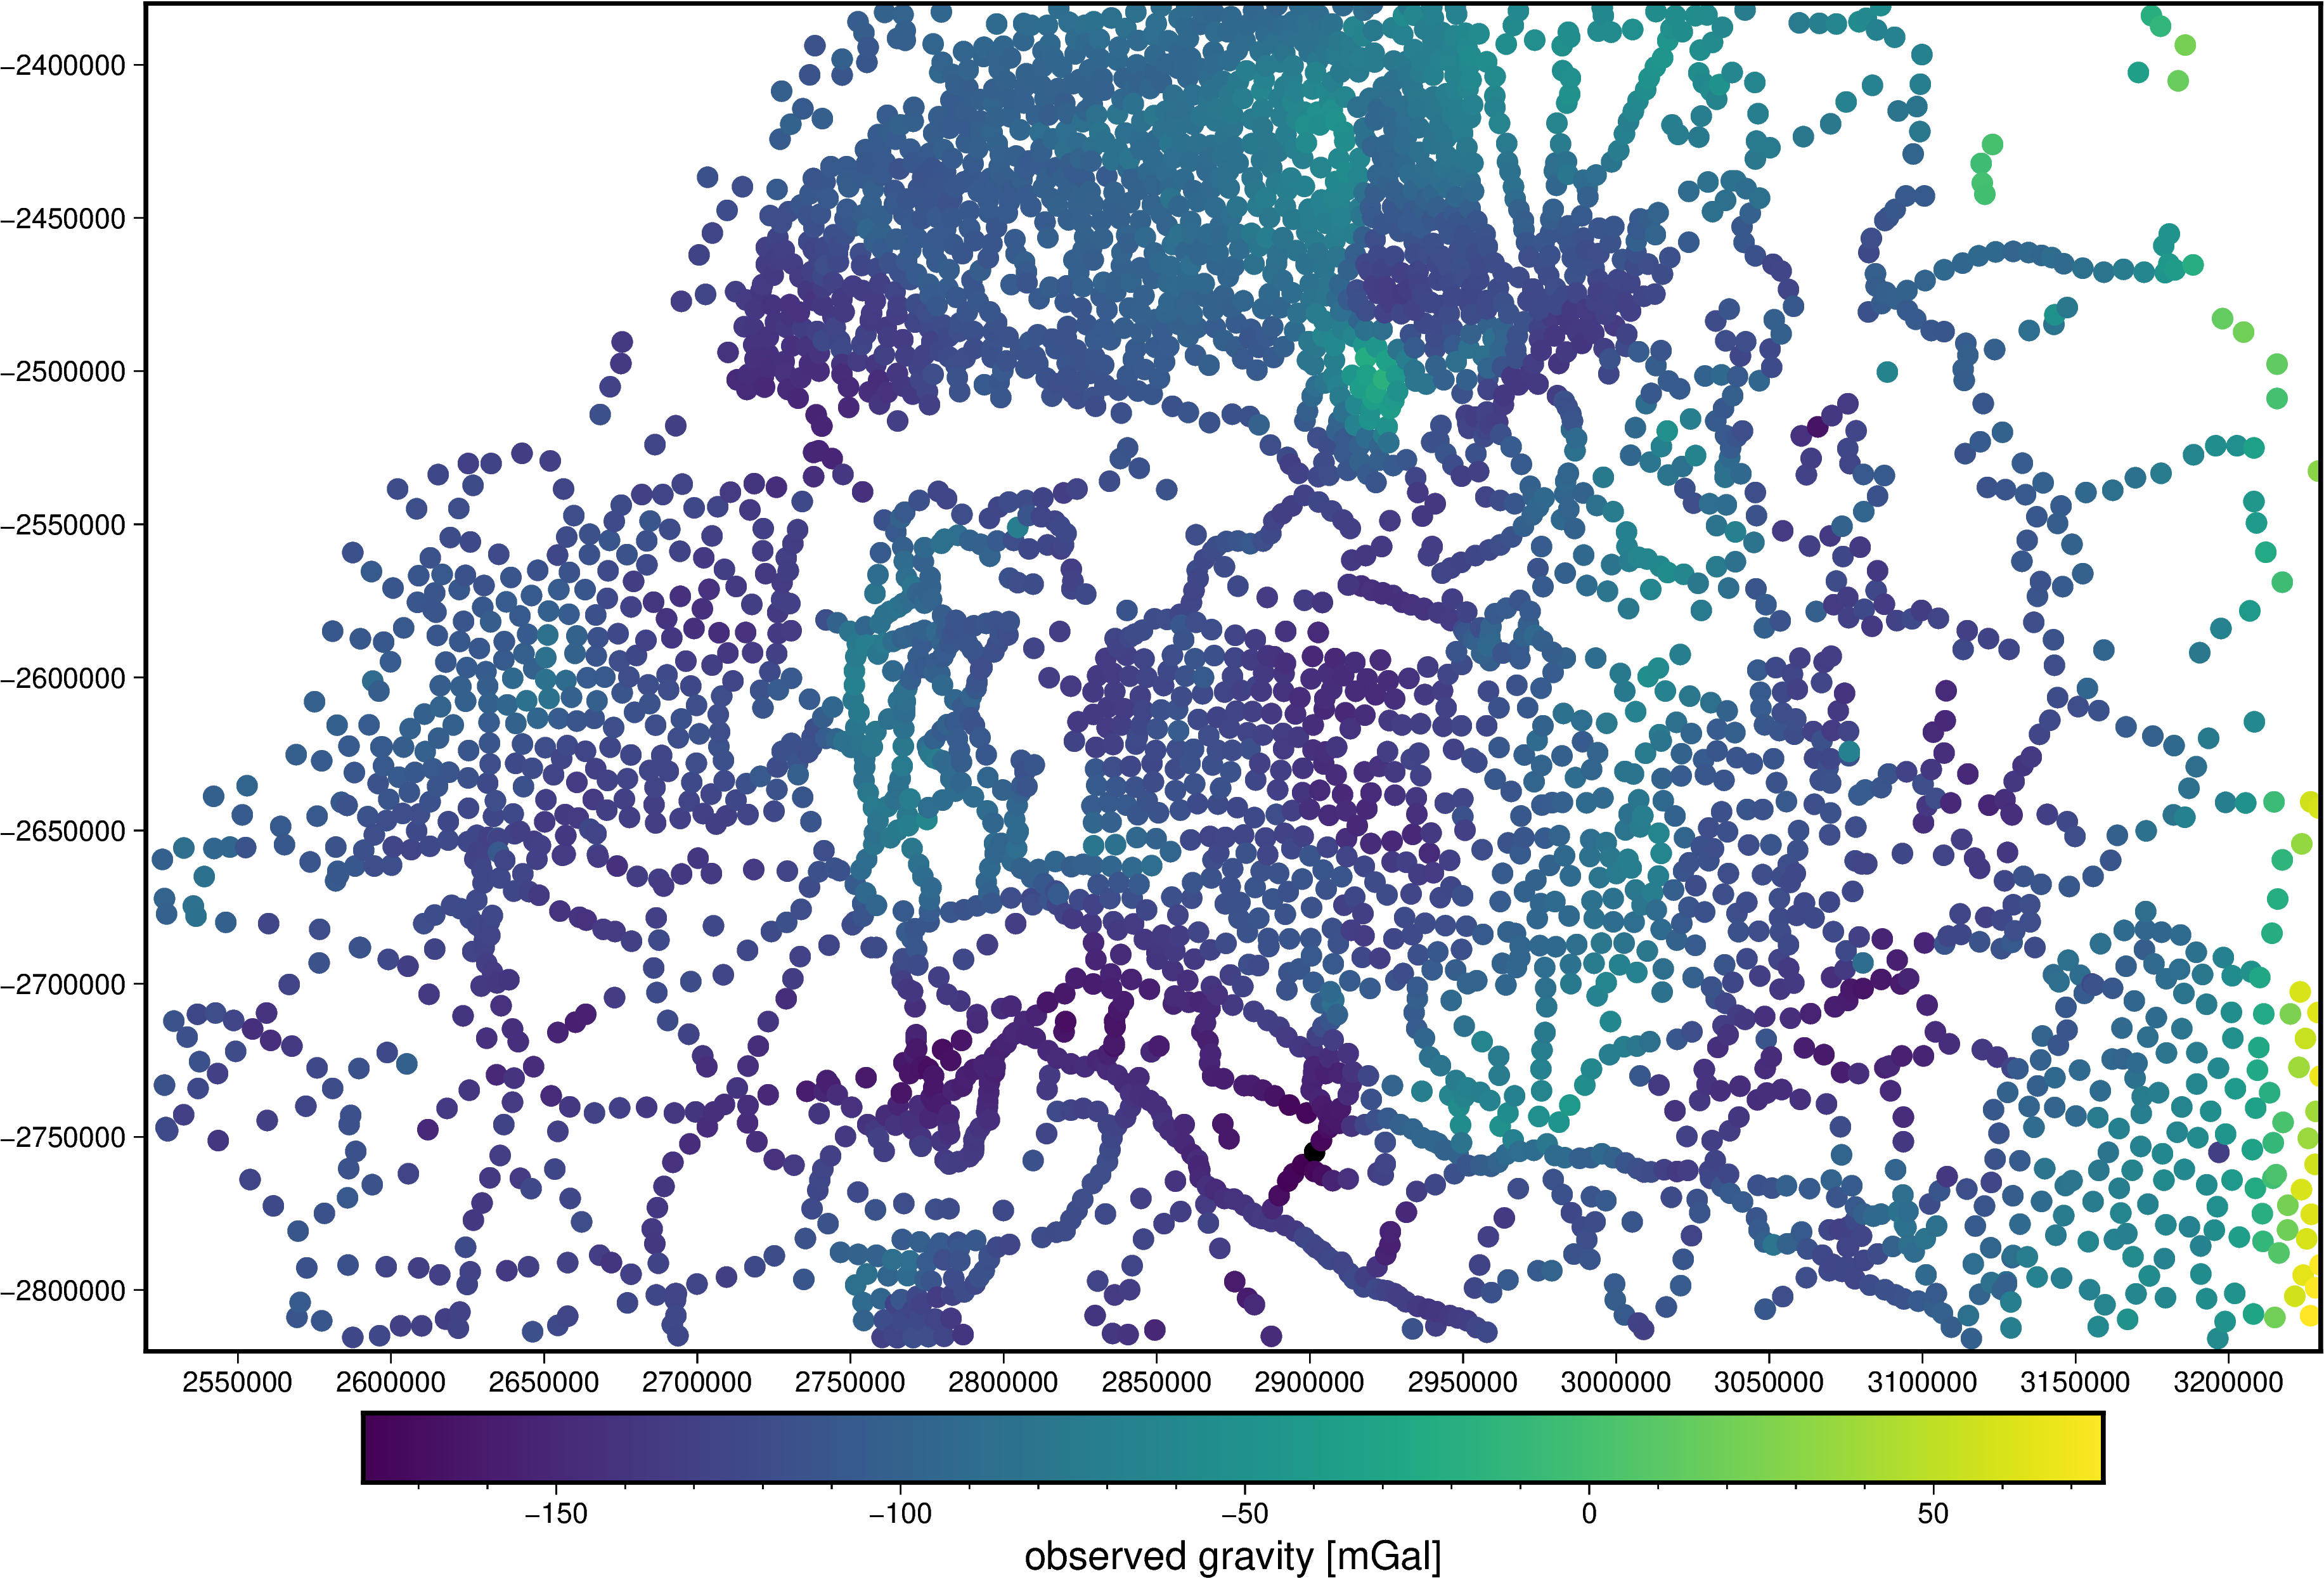

In [13]:
fig = pygmt.Figure()
pygmt.makecpt(
    cmap="viridis",
    series=[data.gravity_bouguer_mgal.min(), data.gravity_bouguer_mgal.max()],
)
fig.plot(
    x=data.easting,
    y=data.northing,
    color=data.gravity_bouguer_mgal,
    cmap=True,
    style="c8p",
    projection=fig_proj,
    region=fig_reg,
    frame=["a", "+gwhite"],
)
fig.colorbar(frame='af+l"observed gravity [mGal]"')
fig.show()

psconvert [ERROR]: Registry registered C:\Program Files (x86)\GPLGS\gswin32c.exe does not exist. Resorting to the one provided in GMT.


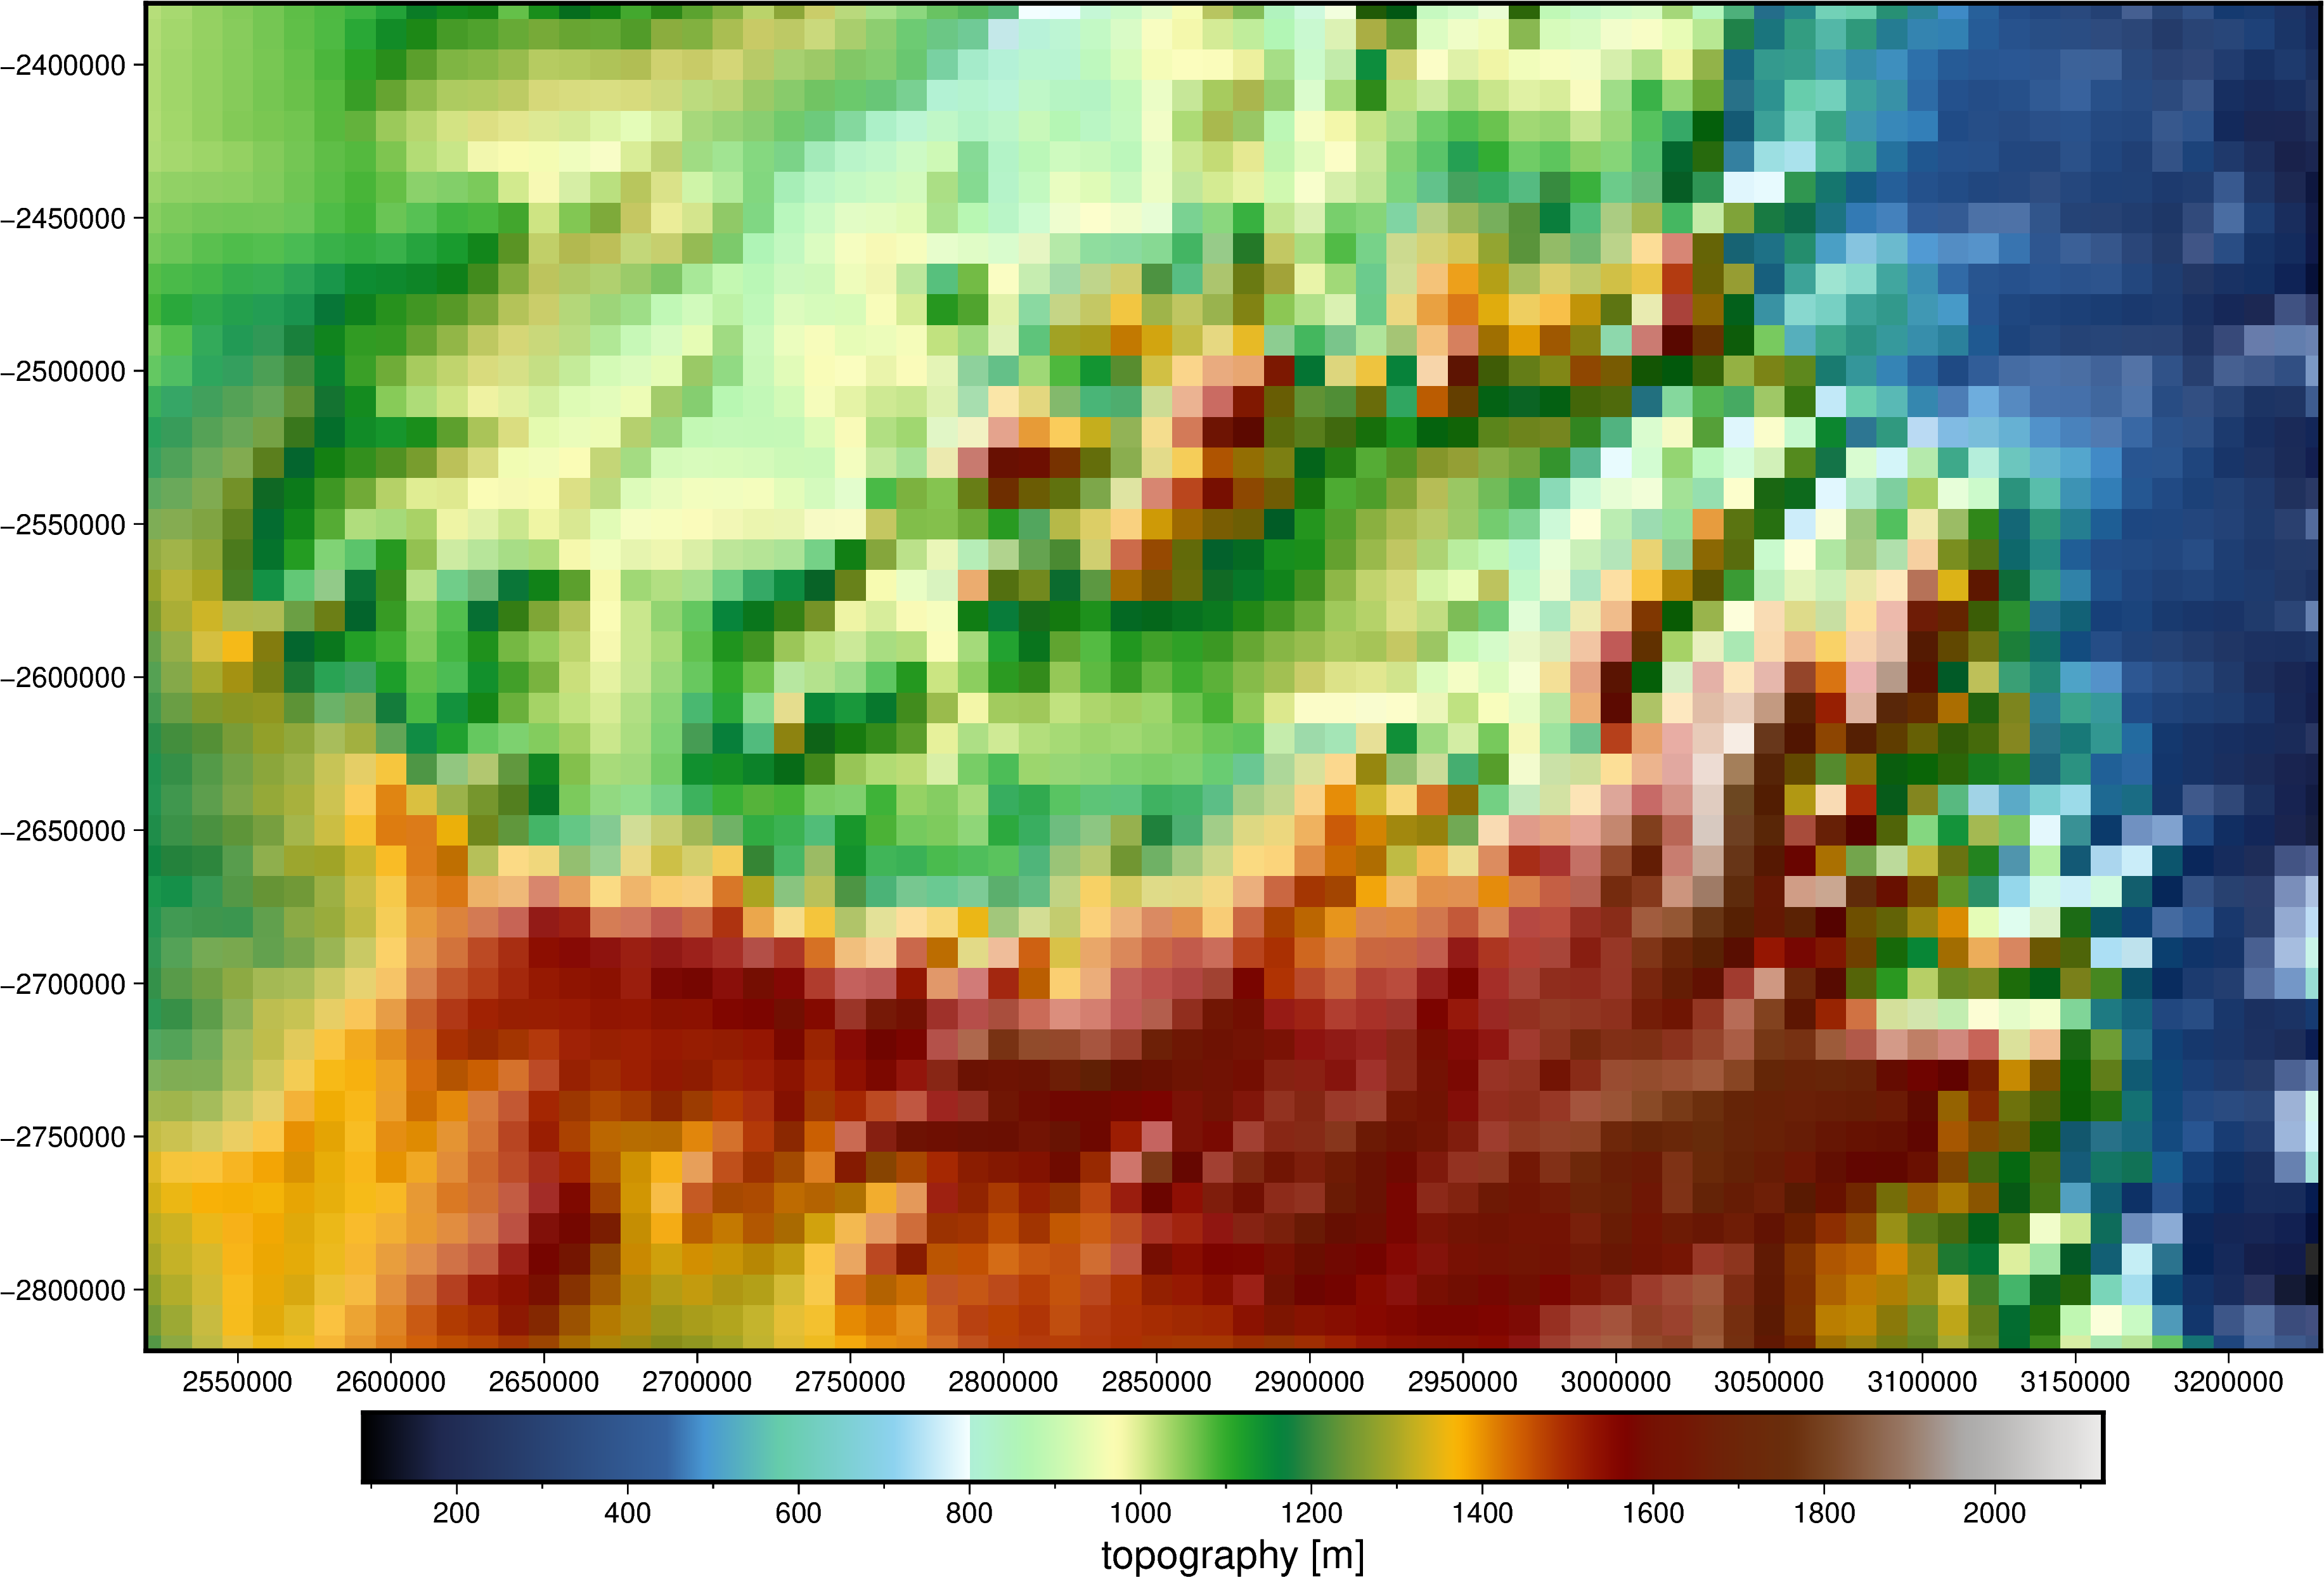

In [113]:
fig = pygmt.Figure()

pygmt.makecpt(
    cmap="earth+h800", series=[np.nanmin(da_topo.values), np.nanmax(da_topo.values)]
)
fig.grdimage(
    da_topo,
    shading=True,
    projection=fig_proj,
    frame=["a", "+gwhite"],
)
fig.colorbar(frame='af+l"topography [m]"')
fig.show()

C:\Users\matthewt\AppData\Local\miniforge3\envs\fatiando\lib\site-packages\pyvista\jupyter\notebook.py:60: UserWarning: Failed to use notebook backend: 

Please install `ipyvtklink` to use this feature: https://github.com/Kitware/ipyvtklink

Falling back to a static output.
  warnings.warn(


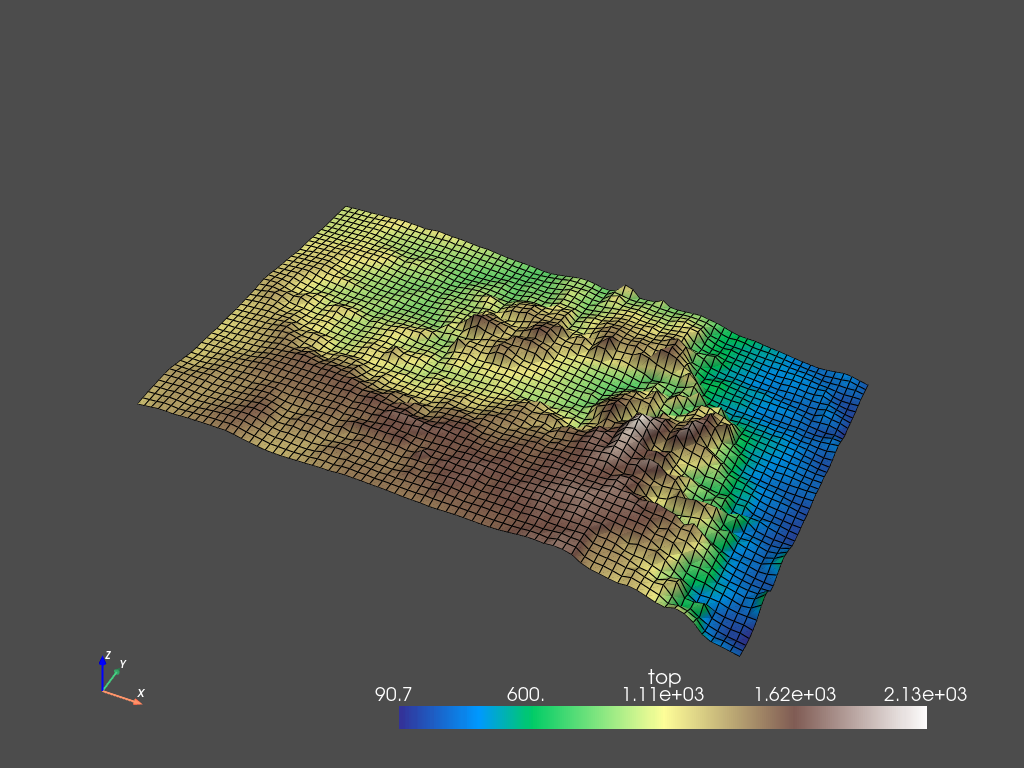

In [114]:
topo_prisms = hm.prism_layer(
    coordinates=(da_topo.x.values, da_topo.y.values),
    surface=da_topo.values,
    reference=-10000,
    properties={"density": 2670 * np.ones_like(da_topo)},
)

# plot from dataarray
data_array = topo_prisms.to_array()
values = np.asarray(data_array)
# Make a mesh
xx, yy = np.meshgrid(data_array["easting"], data_array["northing"])
zz = values.reshape(xx.shape)
mesh = pyvista.StructuredGrid(xx, yy, zz)
# add data to mesh
mesh["data"] = values.reshape(mesh.n_points, -1, order="F")
mesh["top"] = data_array.top.values.reshape(mesh.n_points, -1, order="F")
# warp by topograpy
warped = mesh.warp_by_scalar("top", factor=40)

# plot warped
warped.plot(show_edges=True, cmap="terrain", cpos=(0.1, -0.2, 0.2), notebook=True)

# plot mesh
# mesh.plot(show_edges=True, cmap='terrain', cpos=(.1,-0.2,.2), notebook=True)

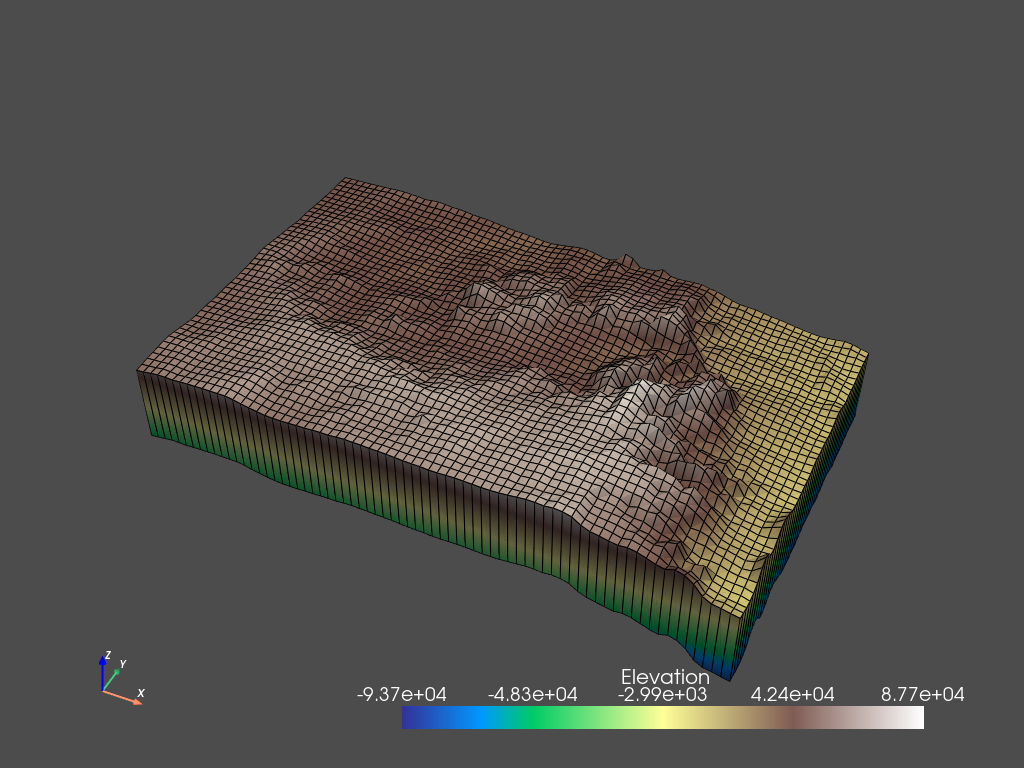

StructuredGrid (0x259c699e3a0)
  N Cells:	3124
  N Points:	6480
  X Bounds:	2.520e+06, 3.230e+06
  Y Bounds:	-2.820e+06, -2.380e+06
  Z Bounds:	-9.370e+04, 8.773e+04
  Dimensions:	45, 72, 2
  N Arrays:	1

In [115]:
# add 5x2500m cells, 3x3500m cells, 2x5000m cells, a 7500m cell and a 10000m cell
z_cells = np.array([2500] * 5 + [3500] * 3 + [5000] * 2 + [7500, 10000])
# add 1x100km cell
z_cells = np.array([0, 100000])

xx = np.repeat(warped.x, len(z_cells), axis=-1)
yy = np.repeat(warped.y, len(z_cells), axis=-1)
zz = np.repeat(warped.z, len(z_cells), axis=-1) - np.cumsum(z_cells).reshape((1, 1, -1))

mesh = pyvista.StructuredGrid(xx, yy, zz)
mesh["Elevation"] = zz.ravel(order="F")

mesh.plot(show_edges=True, cmap="terrain", cpos=(0.1, -0.2, 0.2))
mesh

In [119]:
data

,longitude,latitude,height_sea_level_m,height_geometric_m,gravity_mgal,gravity_disturbance_mgal,gravity_bouguer_mgal,easting,northing
0,25.01500,-26.26334,1230.2,1257.474535,978681.38,25.081592,-113.259165,2.526066e+06,-2.733052e+06
1,25.01932,-26.38713,1297.0,1324.574150,978669.02,24.538158,-122.662101,2.526503e+06,-2.746924e+06
2,25.02499,-26.39667,1304.8,1332.401322,978669.28,26.526960,-121.339321,2.527075e+06,-2.747994e+06
3,25.04500,-26.07668,1165.2,1192.107148,978681.08,17.954814,-113.817543,2.529096e+06,-2.712163e+06
4,25.07668,-26.35001,1262.5,1289.971792,978665.19,12.700307,-130.460126,2.532295e+06,-2.742763e+06
...,...,...,...,...,...,...,...,...,...
3872,31.51500,-23.86333,300.5,312.710241,978776.85,-4.783965,-39.543608,3.182450e+06,-2.466945e+06
3873,31.52499,-23.30000,280.7,292.686630,978798.55,48.012766,16.602026,3.183459e+06,-2.405224e+06
3874,31.54832,-23.19333,245.7,257.592670,978803.55,49.161771,22.456674,3.185814e+06,-2.393567e+06
3875,31.57333,-23.84833,226.8,239.199065,978808.44,5.116904,-20.419870,3.188340e+06,-2.465298e+06


In [121]:
%%time

coordinates = (data.easting, data.northing, data.height_geometric_m)
terrain_effect = topo_prisms.prism_layer.gravity(coordinates, field="g_z")
terrain_effect.shape

CPU times: total: 5.8 s
Wall time: 771 ms


(3877,)

In [133]:
da_topo.values

array([[1213.8538 , 1256.829  , 1301.1362 , ...,  359.79868,  306.24973,
         261.80618],
       [1245.1979 , 1278.9525 , 1312.5    , ...,  289.99994,  226.89058,
         192.05025],
       [1275.3263 , 1303.0742 , 1326.5    , ...,  181.     ,  147.95813,
         113.18734],
       ...,
       [1028.9413 , 1037.975  , 1046.5    , ...,  288.     ,  307.7773 ,
         252.59146],
       [1027.7167 , 1036.9921 , 1045.5    , ...,  365.     ,  294.89508,
         232.32962],
       [1025.4019 , 1035.1539 , 1046.     , ...,  351.5    ,  278.84906,
         222.34436]], dtype=float32)

In [177]:
MATDATPAR.shape

(3877, 3240)

In [172]:
len(Z_Bath), len(Surface_correction)

(3124, 3240)

In [239]:
from grav_column_der import grav_column_der
from scipy.sparse.linalg import lsqr

Least_Squares = 0.001
Tolerance_Least_Squares = 0.02
Max_Iterations = 50

Tolerance_Bathymetry = 100

Tolerance_Bathymetry_Contraints = 100

# Z_Corrected_Bathymetry=ZBath
# Z_Bath_Base_Moho = np.concatenate((ZBath,ZBase,ZM))
# RHO_Bath_Base_Moho = np.concatenate((RHOBath,RHOBase,RHOM))

NG = len(data)
NBath = len(df_topo)
# XCBath, YCBath, =
XBath = df_topo.x
YBath = df_topo.y
Z_Bath = df_topo.bedrock
Z2Bath = 0 * Z_Bath
RESBATH = 10000
RHOBath = np.ones(len(Z_Bath))
RHOBath = RHOBath * 2.4
RHOW_Bath = np.ones(len(Z_Bath))
RHOW_Bath = RHOW_Bath * 1.03

XG = data.easting
YG = data.northing
ZG = data.height_geometric_m


FA_Inversion = data.gravity_bouguer_mgal
MATDATPAR = np.zeros(
    [NG, len(df_topo)]
)  # array with NG number of rows and NBath+NBase+NM number of columns
MAT_DENS = np.zeros([NG, len(df_topo)])

# FA_Inversion = FA - FA_Regional
Grav_Misfit = np.zeros([NG])

CHISQ1 = np.inf  # positive infinity
DCHISQ = np.inf  # positibe infinity

ITER = 0
print("Executing iteration " + str(ITER + 1))
while (
    1 + Tolerance_Least_Squares < DCHISQ
):  # while DCHISQ is greater than 1 + least squares tolerance (0.02)
    ITER = ITER + 1
    print("iteration", ITER)
    FA_Forward = np.zeros([NG])
    for i in range(NG):
        # for each gravity station, will sum up the gravity contributions from each layer's points and add it to a file for each layer
        if np.round(i / NG, decimals=3) == 0.25:
            print("25% done")
        elif np.round(i / NG, decimals=3) == 0.50:
            print("50% done")
        elif np.round(i / NG, decimals=3) == 0.75:
            print("75% done")
        else:
            pass

        FA_Forward = terrain_effect

        # MATDATPAR is matrix array with NG number of rows and NBath+NBase+NM number of columns
        # uses vertical derivative of gravity to find least squares solution to minize gravity misfit for each grav station
        # SURFACE ELEVATION
        MATDATPAR[i, 0:NBath] = grav_column_der(
            XG[i],
            YG[i],
            ZG[i],
            XBath,
            YBath,
            Z_Bath,
            Z2Bath,
            RESBATH,
            RHOBath - RHOW_Bath,
        )  # MATDATPAR[i,0:NBath] is i'th row and columns 0 to NBath

    Grav_Misfit = FA_Inversion - FA_Forward  # this is = FA - FA_Regional - FA_Forward

    # gives the amount that each column's Z1 needs to change by to have the smallest misfit
    Surface_correction = lsqr(
        MATDATPAR, Grav_Misfit, show=False
    )[
        0
    ]  # finds the least-squares solution to MATDATPAR and Grav_Misfit, assigns the first value to Surface_correction

    # if necesarry correction is greater than tolerance, then correction equals tolerance, if it's less than tolerance, then correct by Surface_correction
    for i in range(NBath):
        if Surface_correction[i] > Tolerance_Bathymetry:
            Surface_correction[i] = Tolerance_Bathymetry
        elif Surface_correction[i] < -Tolerance_Bathymetry:
            Surface_correction[i] = -Tolerance_Bathymetry

    # resetting the Z values with the above corrections
    Z_Bath = Z_Bath + Surface_correction
    Z_Corrected_Bathymetry = Z_Bath[0:NBath]

    # if change at constrains is greater than allowed, force to be the max amount
    # for i in range(0,NBath):
    #     # if CPBath[i]==1:
    #     if Z_Corrected_Bathymetry[i] < Z_Bath[i]-Tolerance_Bathymetry_Contraints:
    #         Z_Corrected_Bathymetry[i] = Z_Bath[i]-Tolerance_Bathymetry_Contraints
    #     elif Z_Corrected_Bathymetry[i] > Z_Bath[i]+Tolerance_Bathymetry_Contraints:
    #         Z_Corrected_Bathymetry[i] = Z_Bath[i]+Tolerance_Bathymetry_Contraints

    # for first iteration, divide infinity by mean square of gravity residuals, inversion will stop once this gets to Tolerance_Least_Squares (0.02)
    CHISQ2 = np.mean(Grav_Misfit**2)
    DCHISQ = CHISQ1 / CHISQ2
    CHISQ1 = CHISQ2
    print("mean of misfit^2 (CHISSQ2)", CHISQ2)
    print("DCHISQ=", DCHISQ)
    print("CHISQ1=", CHISQ1)

    print(
        "Iteration "
        + str(ITER)
        + " terminated with least-squares norm="
        + str(CHISQ2)
        + ", executing iteration "
        + str(ITER + 1)
    )

    # stop the inversion if hit the max # iterations or it's below the Least Squares norm
    if Max_Iterations == ITER:
        print(
            "Inversion terminated after "
            + str(ITER)
            + " iterations with least-squares norm="
            + str(CHISQ2)
            + "because maximum number of iterations "
            + str(Max_Iterations)
            + " reached"
        )
        break
    if Least_Squares > CHISQ2:
        print(
            "Inversion terminated after "
            + str(ITER)
            + " iterations with least-squares norm="
            + str(CHISQ2)
            + " because least-squares norm < "
            + str(Least_Squares)
        )
        break

# end of inversion iteration WHILE loop

if 1 + Tolerance_Least_Squares > DCHISQ:
    print("terminated - no significant variation in least-squares norm ")

Executing iteration 1
iteration 1
25% done
25% done
25% done
25% done
50% done
50% done
50% done
50% done
75% done
75% done
75% done
75% done
mean of misfit^2 (CHISSQ2) 1697375.6538040673
DCHISQ= inf
CHISQ1= 1697375.6538040673
Iteration 1 terminated with least-squares norm=1697375.6538040673, executing iteration 2
iteration 2
25% done
25% done
25% done
25% done
50% done
50% done
50% done
50% done
75% done
75% done
75% done
75% done
mean of misfit^2 (CHISSQ2) 1697375.6538040673
DCHISQ= 1.0
CHISQ1= 1697375.6538040673
Iteration 2 terminated with least-squares norm=1697375.6538040673, executing iteration 3
terminated - no significant variation in least-squares norm 


In [240]:
Surface_correction

array([-100.,  100.,  100., ..., -100., -100.,  100.])

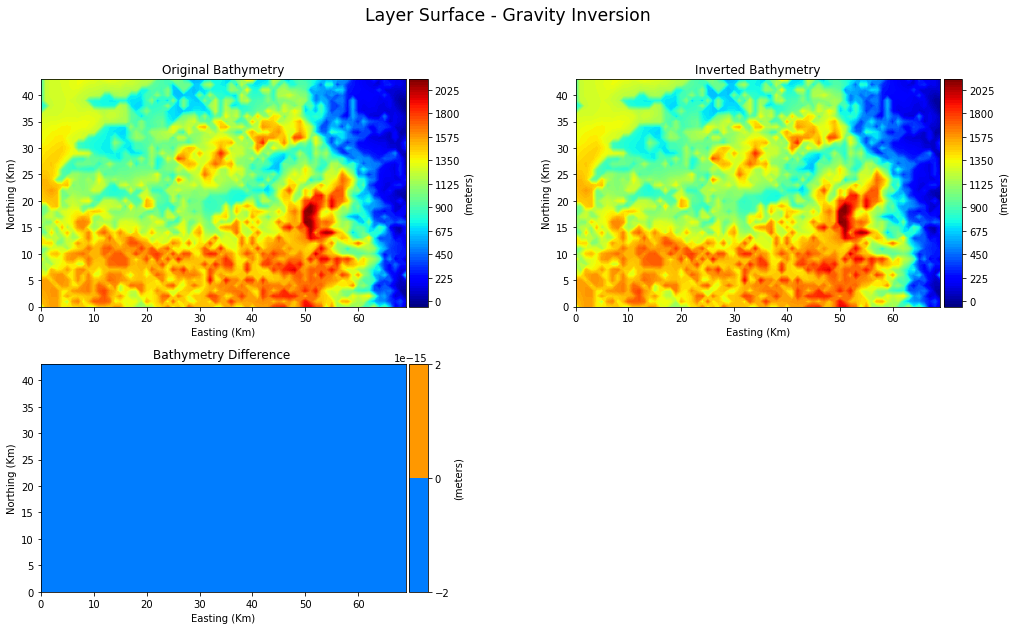

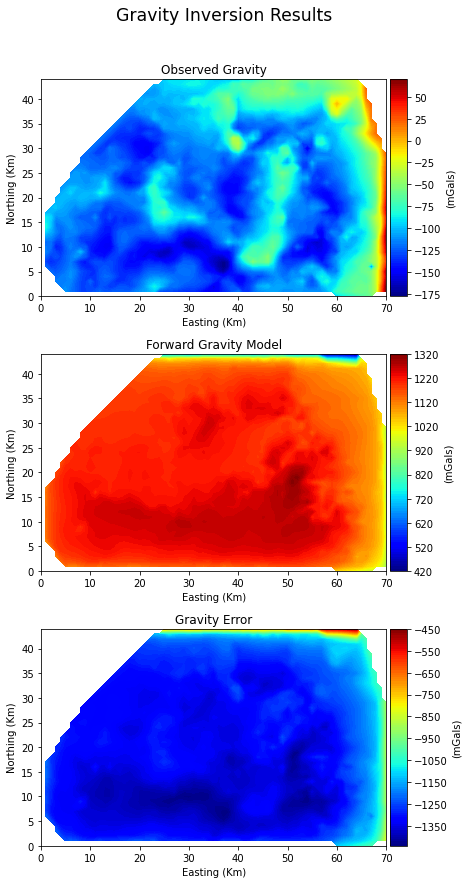

In [241]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import griddata

Bathymetry_Surface_Diff = Z_Bath - Z_Corrected_Bathymetry

XBath_range = np.arange(min(XBath), max(XBath) + 0.0001, RESBATH)
YBath_range = np.arange(min(YBath), max(YBath) + 0.0001, RESBATH)
East_gridBath, North_gridBath = np.meshgrid(XBath_range, YBath_range)

XG_range = np.arange(min(XG), max(XG) + 0.0001, RESBATH)
YG_range = np.arange(min(YG), max(YG) + 0.0001, RESBATH)
East_gridG, North_gridG = np.meshgrid(XG_range, YG_range)

#################################################
# Plotting Inversion Grids
# plotting figure 1 (fig3) in a for-loop
for i in range(3):
    title = (
        "Original Bathymetry",
        "Inverted Bathymetry",
        "Bathymetry Difference ",
    )
    ax = ("ax1", "ax2", "ax3")
    ax = list(ax)
    cax = ("cax1", "cax2", "cax3")
    cax = list(cax)
    img = ("img1", "img2", "img3")
    img = list(img)
    Z = (Z_Bath, Z_Corrected_Bathymetry, Bathymetry_Surface_Diff)
    grid_Z = griddata(
        (XBath, YBath), Z[i], (East_gridBath, North_gridBath), method="linear"
    )
    fig3 = plt.figure(3, (15, 12))
    ax[i] = fig3.add_subplot(3, 2, i + 1, adjustable="box", aspect=1)
    extent = x_min, x_max, y_min, y_max = [min(Y[i]), max(Y[i]), min(X[i]), max(X[i])]
    img[i] = ax[i].contourf(grid_Z, 100, cmap="jet")
    ax[i].set_title(title[i])
    ax[i].set_xlabel("Easting (Km)")
    ax[i].set_ylabel("Northing (Km)")
    divider = make_axes_locatable(ax[i])
    cax[i] = divider.append_axes("right", size="5%", pad=0.05)
    cb3 = fig3.colorbar(img[i], label="(meters)", cax=cax[i])
plt.suptitle("Layer Surface - Gravity Inversion", fontsize="xx-large", y=1.02)
plt.tight_layout()
plt.show()

###########################################
# plotting figure 3 (fig5)in a for-loop
for i in range(3):
    title = ("Observed Gravity", "Forward Gravity Model", "Gravity Error")
    ax = ("ax1", "ax2", "ax3")
    ax = list(ax)
    cax = ("cax1", "cax2", "cax3")
    cax = list(cax)
    img = ("img1", "img2", "img3")
    img = list(img)
    Z = (FA_Inversion, FA_Forward, FA_Inversion - FA_Forward)
    grid_Z = griddata((XG, YG), Z[i], (East_gridG, North_gridG), method="linear")

    # ax[i].plot(XCBath, YCBath, 'ko', markersize=2)

    fig5 = plt.figure(5, (12, 12))
    ax[i] = fig5.add_subplot(3, 1, i + 1, adjustable="box", aspect=1)
    img[i] = ax[i].contourf(grid_Z, 100, cmap="jet")
    ax[i].set_title(title[i])
    ax[i].set_xlabel("Easting (Km)")
    ax[i].set_ylabel("Northing (Km)")
    divider = make_axes_locatable(ax[i])
    cax[i] = divider.append_axes("right", size="5%", pad=0.05)
    cb5 = fig5.colorbar(img[i], label="(mGals)", cax=cax[i])
plt.suptitle("Gravity Inversion Results", fontsize="xx-large", y=1.02)
plt.tight_layout()
plt.show()